In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import random

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [47]:
#Import two datasets
train_df = pd.read_csv("sign_mnist_train.csv")
test_df = pd.read_csv("sign_mnist_test.csv")
print(train_df.shape)
print(test_df.shape)

# Combine datasets for EDA
full_df = pd.concat([train_df, test_df], ignore_index=True)
print(full_df.shape)

(27455, 785)
(7172, 785)
(34627, 785)


In [59]:
#Split the data into x and y variables
#X = full_df.drop(columns="label")
#y = full_df["label"]

X_train = train_df.drop(columns="label")
y_train = train_df["label"]

X_test = test_df.drop(columns="label")
y_test = test_df["label"]
print(sorted(y_train.unique()))
print(sorted(y_test.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [60]:
# Re-indexing labels to remove class 9 and remap the rest
label_map = {k: i for i, k in enumerate(sorted(set(y_train) | set(y_test)))}
y_train = y_train.map(label_map)
y_test = y_test.map(label_map)
print(sorted(y_train.unique()))
print(sorted(y_test.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [62]:
#Reshape greyscale
X_train = X_train.to_numpy().reshape(-1, 28, 28, 1)
X_test = X_test.to_numpy().reshape(-1, 28, 28, 1)

In [63]:
num_classes = 24
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Training data shape: (27455, 28, 28, 1)
Test data shape: (7172, 28, 28, 1)
(27455, 28, 28, 1) (27455, 24)
(7172, 28, 28, 1) (7172, 24)


In [64]:
def create_model(input_shape=(28,28,1), num_classes=24):
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.05))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    
    model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.15))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))

    model.add(Conv2D(16, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.05))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.05))
    model.add(BatchNormalization())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.15))
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.05))
    model.add(BatchNormalization())

    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
model = create_model()

model.compile()

model.summary()

c:\Users\maste\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 59,784 (233.53 KB)

 Trainable params: 59,048 (230.66 KB)

 Non-trainable params: 736 (2.88 KB)

In [65]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

callbacks = [early_stopping, reduce_lr]

In [69]:
batch_size = 32
epochs = 30


# Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=15,
    zoom_range=0.09,
    width_shift_range=0.14,
    height_shift_range=0.14,
    brightness_range = (0.8, 1.00),
    rescale = 1 / 255)

train_flow = datagen.flow(X_train, y_train, batch_size = batch_size)

In [70]:
history = model.fit(
    train_flow,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30


 13/858 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9208 - loss: 0.3346 

c:\Users\maste\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9195 - loss: 0.3348 - val_accuracy: 0.9335 - val_loss: 11.7450 - learning_rate: 1.0000e-04
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9278 - loss: 0.2786 - val_accuracy: 0.9314 - val_loss: 12.8399 - learning_rate: 1.0000e-04
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9314 - loss: 0.2578 - val_accuracy: 0.9453 - val_loss: 9.4500 - learning_rate: 1.0000e-04
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9388 - loss: 0.2264 - val_accuracy: 0.9244 - val_loss: 16.1384 - learning_rate: 1.0000e-04
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9387 - loss: 0.2147 - val_accuracy: 0.9239 - val_loss: 15.5028 - learning_rate: 1.0000e-04
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9441 - loss: 0.1929 - val_accuracy: 0.8986 - val_loss: 23.2353 - learning_rate: 1.0000e-04
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy:

Test Accuracy: 0.9453
Test Loss: 9.4500


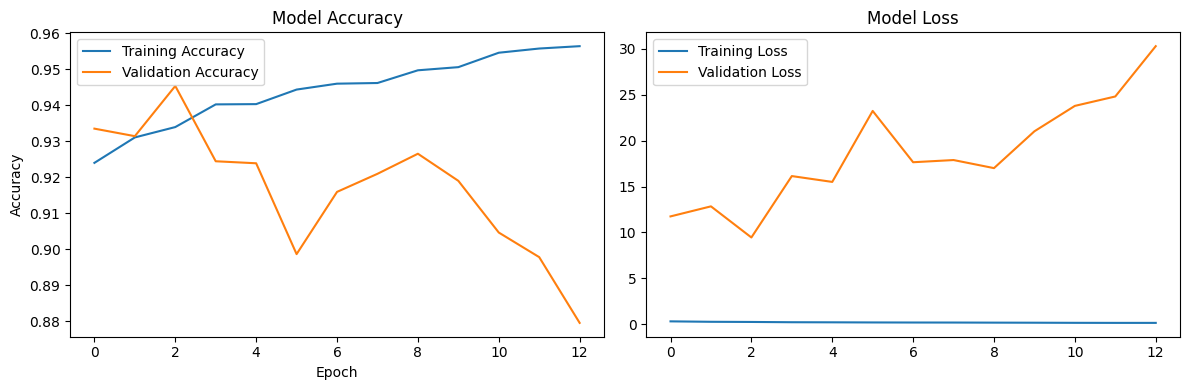

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


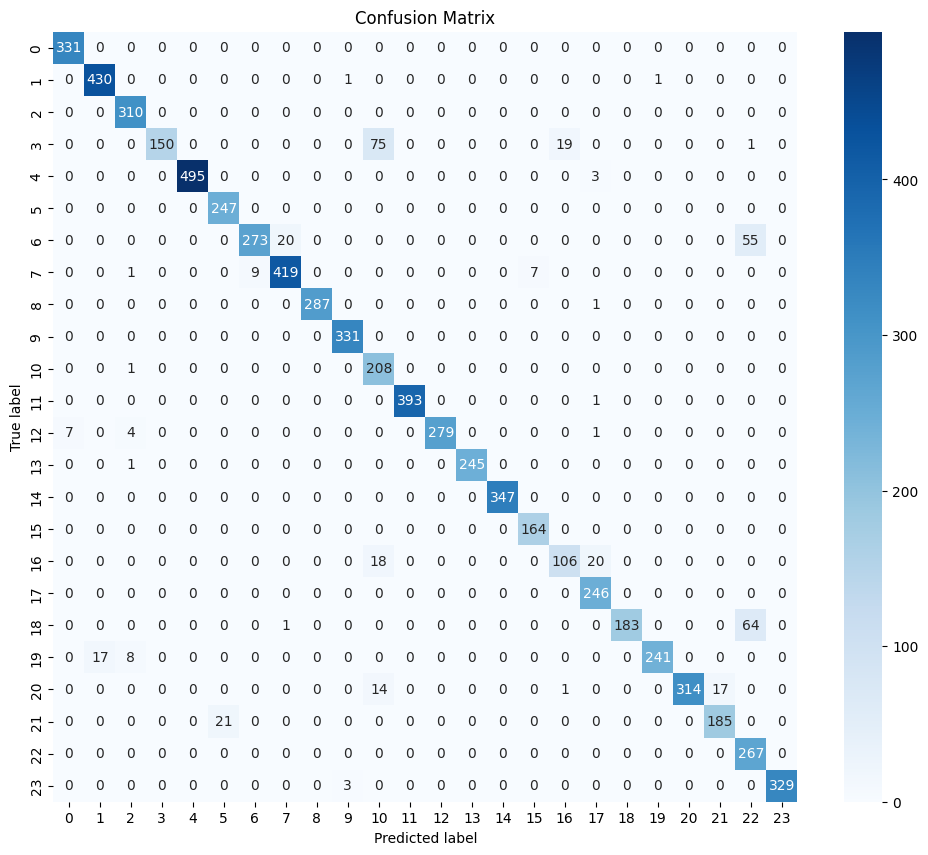

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       331
           1       0.96      1.00      0.98       432
           2       0.95      1.00      0.98       310
           3       1.00      0.61      0.76       245
           4       1.00      0.99      1.00       498
           5       0.92      1.00      0.96       247
           6       0.97      0.78      0.87       348
           7       0.95      0.96      0.96       436
           8       1.00      1.00      1.00       288
           9       0.99      1.00      0.99       331
          10       0.66      1.00      0.79       209
          11       1.00      1.00      1.00       394
          12       1.00      0.96      0.98       291
          13       1.00      1.00      1.00       246
          14       1.00      1.00      1.00       347
          15       0.96      1.00      0.98       164
          16       0.84      0.74      0.79       144
          17       0.90    

In [71]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_true_classes, y_pred_classes))

In [ ]:
model.save('cnn_model.keras')
print("Modellen har sparats som 'cnn_model.keras'")

Modellen har sparats som 'cnn_model.keras'


In [ ]:
model_loaded = load_model('cnn_model.keras')
print("Model loaded successfully!")

Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


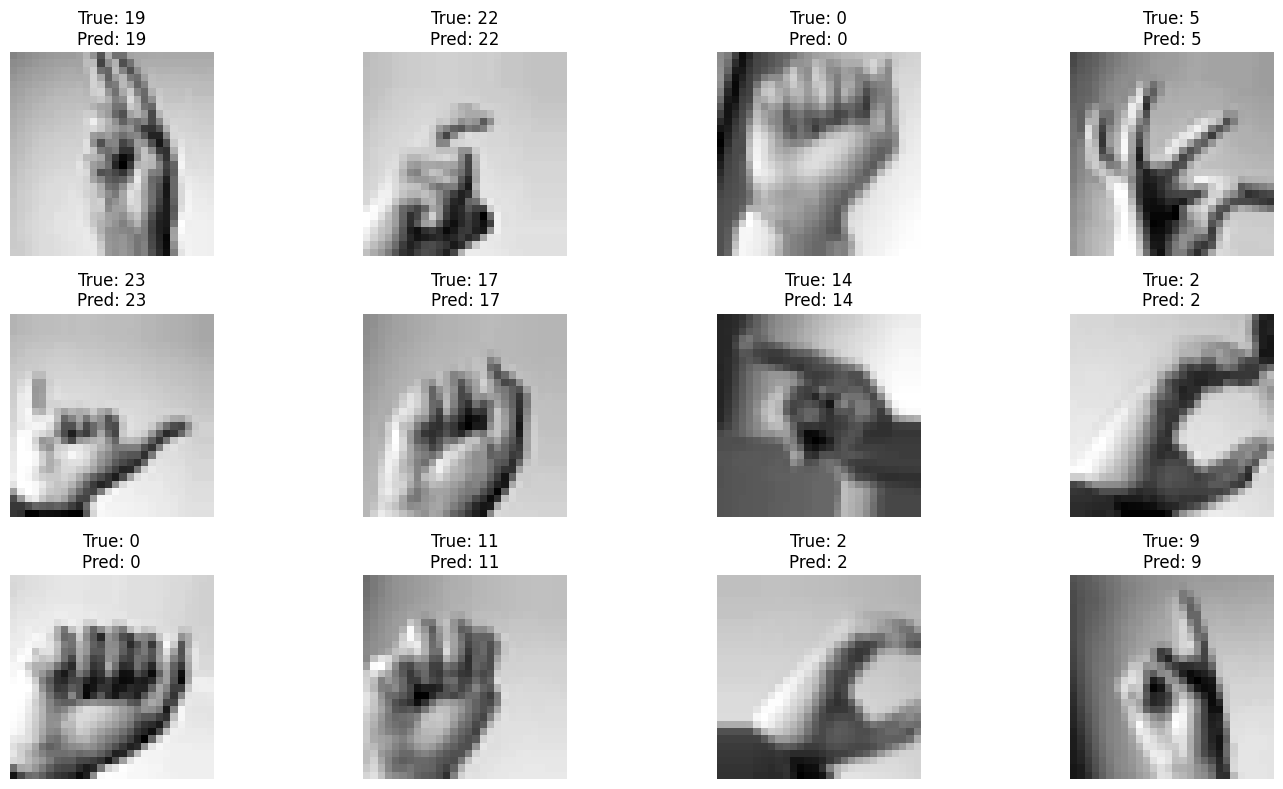

In [75]:
# Get a batch of augmented images and labels from the generator
images, labels = next(train_flow)

# Get model predictions for this batch
preds = model.predict(images)
y_pred_classes = np.argmax(preds, axis=1)
y_true_classes = np.argmax(labels, axis=1)

# Choose 12 random indices from the batch
indices = random.sample(range(len(images)), 12)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"True: {y_true_classes[idx]}\nPred: {y_pred_classes[idx]}")
plt.tight_layout()
plt.show()

In [25]:
print(y_train.sum(axis=0))

[1126. 1010. 1144. 1196.  957. 1204. 1090. 1013. 1162. 1114. 1241. 1055.
 1151. 1196. 1088. 1279. 1294. 1199. 1186. 1161. 1082. 1225. 1164. 1118.]
